# Reconstruction Analysis SiPMs (RASP)

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import time

In [3]:
from dataclasses import dataclass

In [4]:
import invisible_cities.core.system_of_units  as units
from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.io.dst_io    import load_dst
from invisible_cities.core.core_functions import in_range

In [5]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [6]:
from nextflex.core import Setup
from nextflex.core import KEY_sensor_fibres 
from nextflex.core import KEY_sensor_pmts   
from nextflex.core import S1_time           
from nextflex.core import SIPM_ids
from nextflex.core import get_sipm_postions
from nextflex.core import get_sensor_response

In [7]:
from nextflex.graphics_reco   import plot_hits3d

In [8]:
from  tics.stats_tics import bin_data_with_equal_bin_size
from tics.pd_tics   import get_index_slice_from_multi_index
from tics.util_tics   import find_nearest

In [9]:
from nextflex.types import EventHits

In [10]:
from nextflex.types import  ResponseSiPM
from nextflex.reco_functions import get_sipm_response
from nextflex.reco_functions import get_sipm_positions
from nextflex.reco_functions import get_event_sipm
from nextflex.reco_functions import get_sipm_event_hits

In [11]:
from nextflex.graphics_reco   import plot_hits3d
from nextflex.graphics_reco   import plot_hits_projections
from nextflex.graphics_reco   import plot_hits_xy
from nextflex.graphics_reco   import bin_hits
from nextflex.graphics_reco   import bin_hits_xy

In [12]:
from nextflex.tracks_dst import event_reco_hits

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [15]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from skimage.measure import label, regionprops
from skimage import data, util
from skimage.measure import label
from skimage.measure._regionprops import RegionProperties

In [16]:
from nextflex.reco_image_functions import label_slice
from nextflex.reco_image_functions import select_slice_by_label

## Code

## Setup

In [17]:
FDATA = os.environ['FLEXDATA']
testDir  = os.path.join(FDATA,"testSetupData")
print(f"test dir = {testDir}")

test dir = /Users/jj/Development/flexdata/testSetupData


In [18]:
setbb = Setup(flexDATA = testDir,
              tpConfig = "FLEX100_M6_O6.EL8bar.bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu
        analysis directory           = /Users/jj/Development/flexdata/testSetupData/analysis/FLEX100_M6_O6.EL8bar.bb0nu
        number of h5 files in dir    = 1
        sipm map at                  = /Users/jj/Development/flexdata/testSetupData/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/testSetupData/kdsts/FLEX100_M6_O

In [19]:
setbb.ifnames[0]

'/Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5'

In [20]:
setbb.pitch

15.55

In [21]:
setbb.mc_config()

,param_value
param_key,
num_events,4
TP_SiPM_binning,1.000000 mus
/Geometry/NextFlex/e_lifetime,1000. ms
/Geometry/NextFlex/el_gap_length,10. mm
/Geometry/NextFlex/el_field_int,16. kilovolt/cm
/Geometry/NextFlex/tp_teflon_thickness,6. mm
/Geometry/NextFlex/tp_teflon_hole_diam,6. mm
/Geometry/NextFlex/tp_sipm_sizeX,1.3 mm
/Geometry/NextFlex/tp_sipm_pitchX,15.55 mm


In [22]:
setbb.mc_config().index

Index(['num_events', 'TP_SiPM_binning', '/Geometry/NextFlex/e_lifetime',
       '/Geometry/NextFlex/el_gap_length', '/Geometry/NextFlex/el_field_int',
       '/Geometry/NextFlex/tp_teflon_thickness',
       '/Geometry/NextFlex/tp_teflon_hole_diam',
       '/Geometry/NextFlex/tp_sipm_sizeX',
       '/Geometry/NextFlex/tp_sipm_pitchX'],
      dtype='object', name='param_key')

In [23]:
int(setbb.mc_config().loc['num_events'].values[0])

4

In [24]:
float(setbb.mc_config().loc['TP_SiPM_binning'].values[0].split(" ")[0])

1.0

## Sensors

#### Index for PMTs, fibres and SiPMs

In [25]:
print(f"""
KEY_sensor_fibres > {KEY_sensor_fibres} 
KEY_sensor_pmts   < {KEY_sensor_pmts}
{KEY_sensor_pmts} KEY_sensor_sipms < {KEY_sensor_fibres}""")


KEY_sensor_fibres > 100000 
KEY_sensor_pmts   < 100
100 KEY_sensor_sipms < 100000


### Binning, type, etc

In [26]:
setbb.sensor_binning

,bin_width
sns_name,
PmtR11410,25.0
TP_SiPM,1000.0


In [27]:
setbb.sensor_binning.index.values

array(['PmtR11410', 'TP_SiPM'], dtype=object)

In [28]:
setbb.sensor_binning.bin_width.values

array([  25., 1000.])

In [29]:
setbb.sensor_types

,sensor_id,sensor_name
0,10,PmtR11410
1,32,PmtR11410
2,42,PmtR11410
3,12,PmtR11410
4,29,PmtR11410
...,...,...
3148,3723,TP_SiPM
3149,2989,TP_SiPM
3150,2550,TP_SiPM
3151,2118,TP_SiPM


In [30]:
setbb.sensors

array(['PmtR11410', 'TP_SiPM'], dtype=object)

In [31]:
setbb.nesens

60

In [32]:
setbb.nsipm

3093

### Positions and response

##### get_sipm_response

In [33]:
ifname = setbb.ifnames[0]

In [34]:
start_time = time.perf_counter() 
sipm_response = get_sipm_response(ifname)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")

run time = 0.2815980280000012


In [35]:
sipm_response

<ResponseSiPM>
        Columns = ('charge', 'time')
        Indexes = ('event_id', 'sensor_id')
        

In [36]:
sipmr = sipm_response.df
sipmr

charge       time
event_id sensor_id                   
212      1000            2   761000.0
         1000            2   762000.0
         1000            1   763000.0
         1000            2   764000.0
         1000            5   765000.0
...                    ...        ...
215      4092            1  1076000.0
         4092            1  1079000.0
         4092            2  1082000.0
         4092            1  1083000.0
         4092            2  1085000.0

[151846 rows x 2 columns]

In [37]:
sipm_evts = get_index_slice_from_multi_index(sipmr, i = 0)

In [38]:
sipm_evts

array([212, 213, 214, 215])

In [39]:
np.allclose(sipm_evts, np.array([212, 213, 214, 215]))

True

In [40]:
sipm_ids = get_index_slice_from_multi_index(sipmr, i = 1)

In [41]:
sipm_ids

array([1000, 1001, 1002, ..., 4090, 4091, 4092])

In [42]:
len(sipm_ids)

3093

##### get_sipm_positions

In [43]:
sipm_positions = get_sipm_positions(ifname)

In [44]:
sipmp = sipm_positions.df

In [45]:
sipmp

,sensor_id,x,y,z
0,1307,279.899994,-342.100006,-23.301001
1,1155,-139.949997,-388.750000,-23.301001
2,1317,-279.899994,-326.549988,-23.301001
3,1120,-124.400002,-404.299988,-23.301001
4,1205,31.100000,-373.200012,-23.301001
...,...,...,...,...
3088,3723,217.699997,311.000000,-23.301001
3089,2989,108.849998,108.849998,-23.301001
3090,2550,62.200001,0.000000,-23.301001
3091,2118,124.400002,-108.849998,-23.301001


In [46]:
sipmp.sensor_id.min()

1000

In [47]:
sipmp.sensor_id.max()

4092

In [51]:
print(f""" 
xmin = {sipmp.x.min()}, 
xmax ={sipmp.x.max()}
ymin = {sipmp.y.min()}, 
ymax ={sipmp.y.max()}
""")

 
xmin = -482.04998779296875, 
xmax =482.04998779296875
ymin = -482.04998779296875, 
ymax =482.04998779296875



In [53]:
events = get_index_slice_from_multi_index(sipm_response.df, i = 0)
events

array([212, 213, 214, 215])

In [54]:
sipm_evt      = get_event_sipm(sipm_response, events[0])

In [55]:
sipm_evt

<EventSiPM>
        event number = 212
        Columns = ('charge', 'time')
        

In [56]:
sipm_evt.df

charge      time
event_id sensor_id                  
212      1000            2  761000.0
         1000            2  762000.0
         1000            1  763000.0
         1000            2  764000.0
         1000            5  765000.0
...                    ...       ...
         4092            1  800000.0
         4092            1  801000.0
         4092            1  802000.0
         4092            1  803000.0
         4092            1  908000.0

[35580 rows x 2 columns]

In [57]:
np.unique(sipm_evt.df.index.get_level_values("event_id"))[0] == sipm_evt.event_id

True

In [58]:
len(get_index_slice_from_multi_index(sipm_evt.df, i = 1))

3093

### SiPM Hits

#### Effect of energy cut

##### No cut

In [67]:
start_time = time.perf_counter() 
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut = 0)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")                 

run time = 5.230702145999999


In [68]:
hitsdf = sipm_hits.df

In [69]:
hitsdf

,x,y,z,energy
0,-62.200001,-482.049988,761.0,2
1,-62.200001,-482.049988,762.0,2
2,-62.200001,-482.049988,763.0,1
3,-62.200001,-482.049988,764.0,2
4,-62.200001,-482.049988,765.0,5
...,...,...,...,...
35575,62.200001,482.049988,800.0,1
35576,62.200001,482.049988,801.0,1
35577,62.200001,482.049988,802.0,1
35578,62.200001,482.049988,803.0,1


In [70]:
etot = hitsdf.energy.sum()

In [71]:
etot

78886

##### Most signals from the SiPMs are very low (1 count)

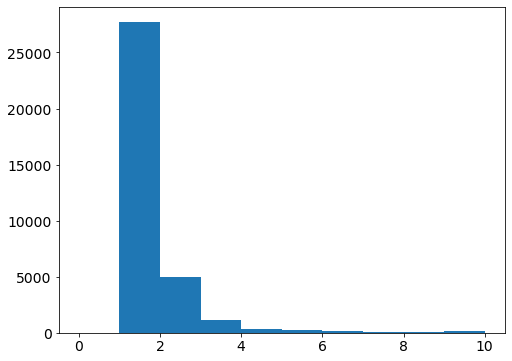

In [62]:
_ = plt.hist(hitsdf.energy, range=(0,10))

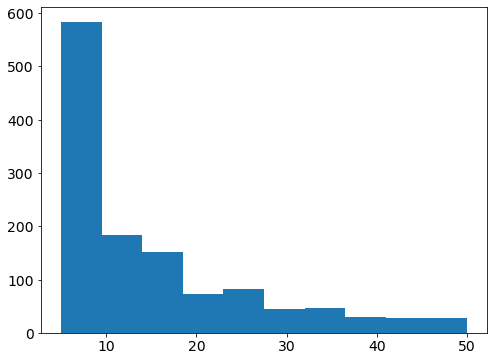

In [63]:
_ = plt.hist(hitsdf.energy, range=(5,50))

##### Cutting at 5 pes

In [79]:
start_time = time.perf_counter() 
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut = 5)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")                 

run time = 0.14329801200000247


In [73]:
sipm_hits.df

,x,y,z,energy
0,-62.200001,-482.049988,785.0,7
1,-62.200001,-482.049988,786.0,6
2,-62.200001,-482.049988,787.0,13
3,-62.200001,-482.049988,788.0,9
4,-62.200001,-482.049988,789.0,8
...,...,...,...,...
1214,-93.300003,-139.949997,903.0,6
1215,-93.300003,-139.949997,904.0,6
1216,-93.300003,-139.949997,905.0,8
1217,-435.399994,-124.400002,788.0,6


In [81]:
etot5 = sipm_hits.df.energy.sum()

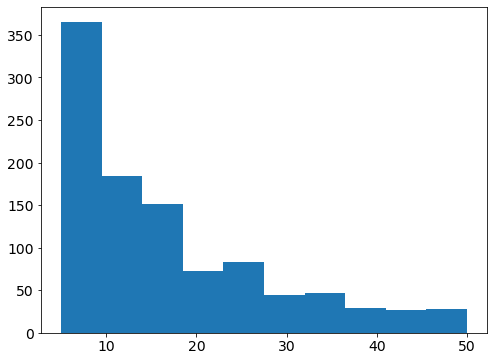

In [66]:
_ = plt.hist(sipm_hits.df.energy, range=(5,50))

##### Cutting at 10 pes

In [82]:
start_time = time.perf_counter() 
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut = 10)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f"run time = {run_time}")                 

run time = 0.08478656000005458


In [83]:
sipm_hits.df

,x,y,z,energy
0,-62.200001,-482.049988,787.0,13
1,-139.949997,-466.500000,764.0,17
2,-139.949997,-466.500000,769.0,12
3,-139.949997,-466.500000,781.0,13
4,-139.949997,-466.500000,784.0,19
...,...,...,...,...
799,-93.300003,-155.500000,904.0,27
800,-93.300003,-155.500000,905.0,19
801,-93.300003,-155.500000,906.0,11
802,-108.849998,-139.949997,902.0,13


In [84]:
etot10 = sipm_hits.df.energy.sum()

In [85]:
print(f"etot = {etot}, etot (5 pes) ={etot5},  etot (10 pes) = {etot10}")

etot = 78886, etot (5 pes) =35351,  etot (10 pes) = 32201


#### Plot hits

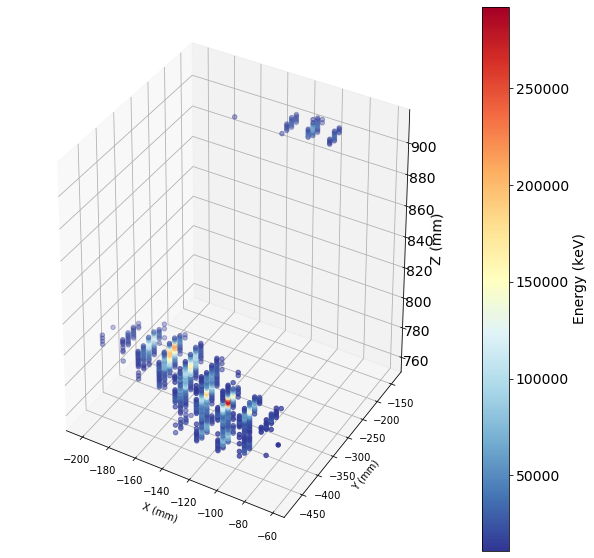

In [86]:
plot_hits3d(sipm_hits,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [94]:
binHits = bin_hits(sipm_hits)

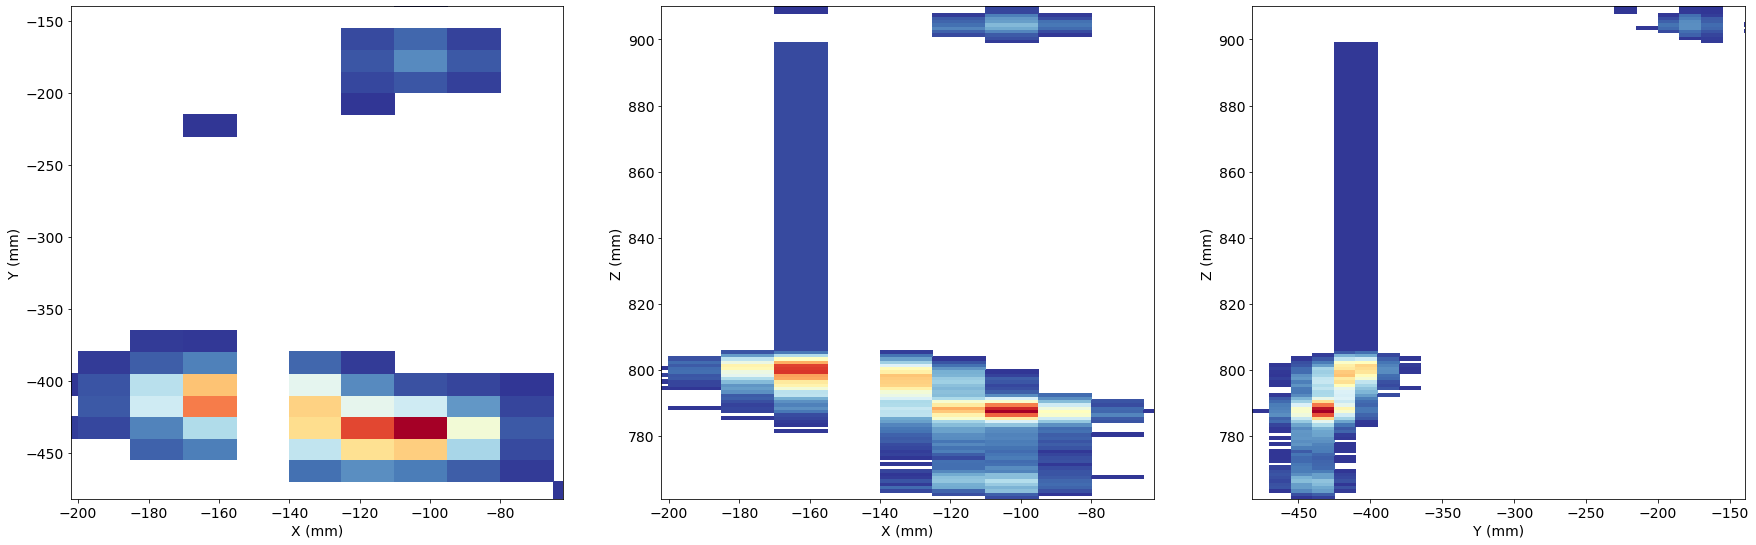

In [97]:
plot_hits_projections(sipm_hits, binHits,  masked=True, figsize=(30, 10))